In [7]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz


Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


### Create placeholder 

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z


### Create generator

In [10]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)  # Leaky ReLU
        
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out
    

### Create discriminator 

In [11]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


### Initialize hyper parameters

In [12]:
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

### Define the graph of GAN model

In [13]:
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)


W0830 12:26:15.554110 13972 deprecation.py:323] From <ipython-input-10-9c158cb902f0>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


W0830 12:26:15.583027 13972 deprecation.py:506] From C:\Users\hiro\Anaconda3\envs\GAN_introduction\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### define loss functions

In [14]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)))


W0830 12:26:16.282150 13972 deprecation.py:323] From C:\Users\hiro\Anaconda3\envs\GAN_introduction\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Define a learning rate

In [15]:
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

### Check the batch data

In [16]:
batch_size = 100
batch = mnist.train.next_batch(batch_size)

In [17]:
batch

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([6, 0, 1, 4, 6, 0, 8, 8, 2, 5, 2, 8, 7, 2, 0, 5, 6, 8, 6, 7, 8, 1,
        2, 6, 1, 1, 4, 2, 9, 8, 2, 8, 9, 9, 9, 1, 5, 9, 7, 9, 6, 8, 4, 2,
        4, 4, 7, 6, 0, 2, 8, 6, 4, 4, 5, 8, 3, 9, 7, 8, 5, 9, 2, 9, 6, 8,
        0, 8, 4, 3, 8, 7, 9, 1, 8, 6, 6, 2, 4, 5, 7, 1, 0, 2, 3, 4, 1, 3,
        5, 2, 2, 7, 1, 5, 9, 9, 9, 3, 9, 3], dtype=uint8))

In [18]:
batch[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [19]:
batch[1][0]

6

### Implement training

In [20]:
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            
            # Generator
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            _ = sess.run(d_train_optimize, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_optimize, feed_dict={input_z: batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print('エポック数 {}/{}'.format(e + 1, epochs),
              'D ロス: {:.4f}'.format(train_loss_d),
              'G ロス: {:.4f}'.format(train_loss_g))
        
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                               feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        
with open('training_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
    

エポック数 1/100 D ロス: 0.3824 G ロス: 3.2805


エポック数 2/100 D ロス: 0.5495 G ロス: 2.2575


エポック数 3/100 D ロス: 0.7505 G ロス: 4.2413


エポック数 4/100 D ロス: 0.6302 G ロス: 4.4537


エポック数 5/100 D ロス: 0.6325 G ロス: 3.6664


エポック数 6/100 D ロス: 1.1476 G ロス: 3.4409


エポック数 7/100 D ロス: 0.6484 G ロス: 3.8310


エポック数 8/100 D ロス: 1.1688 G ロス: 3.5474


エポック数 9/100 D ロス: 0.7559 G ロス: 2.6681


エポック数 10/100 D ロス: 0.9401 G ロス: 4.2876


エポック数 11/100 D ロス: 1.1956 G ロス: 2.5240


エポック数 12/100 D ロス: 1.2148 G ロス: 2.3147


エポック数 13/100 D ロス: 1.1717 G ロス: 1.9555


エポック数 14/100 D ロス: 1.2123 G ロス: 1.3914


エポック数 15/100 D ロス: 0.7617 G ロス: 3.6982


エポック数 16/100 D ロス: 0.9272 G ロス: 2.8311


エポック数 17/100 D ロス: 1.2618 G ロス: 2.4057


エポック数 18/100 D ロス: 1.1748 G ロス: 1.8372


エポック数 19/100 D ロス: 0.9830 G ロス: 2.1638


エポック数 20/100 D ロス: 1.0137 G ロス: 2.5420


エポック数 21/100 D ロス: 0.9135 G ロス: 2.0039


エポック数 22/100 D ロス: 1.1837 G ロス: 1.4560


エポック数 23/100 D ロス: 1.0553 G ロス: 2.2196


エポック数 24/100 D ロス: 1.0805 G ロス: 1.4591


エポック数 25/100 D ロス: 0.7853 G ロス: 2.3575


エポック数 26/100 D ロス: 1.3491 G ロス: 2.6003


エポック数 27/100 D ロス: 1.1226 G ロス: 1.5183


エポック数 28/100 D ロス: 0.8891 G ロス: 1.8112


エポック数 29/100 D ロス: 1.2447 G ロス: 1.6492


エポック数 30/100 D ロス: 1.0190 G ロス: 2.1488


エポック数 31/100 D ロス: 0.9018 G ロス: 2.1161


エポック数 32/100 D ロス: 1.0588 G ロス: 1.7656


エポック数 33/100 D ロス: 1.0002 G ロス: 1.7776


エポック数 34/100 D ロス: 1.1289 G ロス: 1.9724


エポック数 35/100 D ロス: 0.9724 G ロス: 2.6458


エポック数 36/100 D ロス: 1.1726 G ロス: 2.4064


エポック数 37/100 D ロス: 0.8836 G ロス: 1.8809


エポック数 38/100 D ロス: 0.9004 G ロス: 2.2723


エポック数 39/100 D ロス: 0.9363 G ロス: 1.8625


エポック数 40/100 D ロス: 1.1286 G ロス: 1.1411


エポック数 41/100 D ロス: 0.9076 G ロス: 2.3723


エポック数 42/100 D ロス: 0.8151 G ロス: 1.9279


エポック数 43/100 D ロス: 0.9637 G ロス: 1.8690


エポック数 44/100 D ロス: 1.0514 G ロス: 2.3183


エポック数 45/100 D ロス: 0.9611 G ロス: 1.9104


エポック数 46/100 D ロス: 1.1203 G ロス: 1.5445


エポック数 47/100 D ロス: 0.9196 G ロス: 1.9999


エポック数 48/100 D ロス: 0.9915 G ロス: 1.6308


エポック数 49/100 D ロス: 0.9832 G ロス: 2.4209


エポック数 50/100 D ロス: 1.0167 G ロス: 1.7618


エポック数 51/100 D ロス: 0.9490 G ロス: 1.7573


エポック数 52/100 D ロス: 0.8972 G ロス: 1.8908


エポック数 53/100 D ロス: 0.8586 G ロス: 1.9380


エポック数 54/100 D ロス: 0.9361 G ロス: 2.0609


エポック数 55/100 D ロス: 0.9782 G ロス: 1.9888


エポック数 56/100 D ロス: 1.0091 G ロス: 1.9193


エポック数 57/100 D ロス: 0.9734 G ロス: 2.1569


エポック数 58/100 D ロス: 0.7609 G ロス: 2.1156


エポック数 59/100 D ロス: 0.9846 G ロス: 2.1058


エポック数 60/100 D ロス: 0.8117 G ロス: 2.3016


エポック数 61/100 D ロス: 0.8323 G ロス: 2.1575


エポック数 62/100 D ロス: 0.7691 G ロス: 1.9955


エポック数 63/100 D ロス: 0.8583 G ロス: 1.8139


エポック数 64/100 D ロス: 0.9166 G ロス: 2.0589


エポック数 65/100 D ロス: 0.7964 G ロス: 2.1962


エポック数 66/100 D ロス: 0.9052 G ロス: 1.6316


エポック数 67/100 D ロス: 0.9826 G ロス: 2.0987


エポック数 68/100 D ロス: 0.9494 G ロス: 2.4456


エポック数 69/100 D ロス: 0.7580 G ロス: 2.5781


エポック数 70/100 D ロス: 0.9458 G ロス: 2.0440


エポック数 71/100 D ロス: 0.8734 G ロス: 2.3130


エポック数 72/100 D ロス: 0.7474 G ロス: 2.7403


エポック数 73/100 D ロス: 0.8788 G ロス: 2.1260


エポック数 74/100 D ロス: 0.9397 G ロス: 1.7050


エポック数 75/100 D ロス: 0.9110 G ロス: 1.8320


エポック数 76/100 D ロス: 1.0149 G ロス: 1.5647


エポック数 77/100 D ロス: 1.0249 G ロス: 1.8341


エポック数 78/100 D ロス: 1.0877 G ロス: 1.9696


エポック数 79/100 D ロス: 0.8938 G ロス: 2.0299


エポック数 80/100 D ロス: 0.9102 G ロス: 1.9011


エポック数 81/100 D ロス: 0.8965 G ロス: 1.9089


エポック数 82/100 D ロス: 0.9346 G ロス: 2.4321


エポック数 83/100 D ロス: 1.0437 G ロス: 1.5090


エポック数 84/100 D ロス: 0.8633 G ロス: 2.0683


エポック数 85/100 D ロス: 0.9788 G ロス: 2.2931


エポック数 86/100 D ロス: 1.0135 G ロス: 1.8112


エポック数 87/100 D ロス: 1.0617 G ロス: 1.5013


エポック数 88/100 D ロス: 1.0156 G ロス: 1.7916


エポック数 89/100 D ロス: 1.0310 G ロス: 1.9010


エポック数 90/100 D ロス: 0.9799 G ロス: 2.4396


エポック数 91/100 D ロス: 0.8048 G ロス: 1.8204


エポック数 92/100 D ロス: 0.9690 G ロス: 1.6533


エポック数 93/100 D ロス: 0.9352 G ロス: 1.7494


エポック数 94/100 D ロス: 1.0954 G ロス: 2.0074


エポック数 95/100 D ロス: 0.9007 G ロス: 1.9040


エポック数 96/100 D ロス: 1.0290 G ロス: 2.0139


エポック数 97/100 D ロス: 0.9527 G ロス: 2.0040


エポック数 98/100 D ロス: 0.9801 G ロス: 1.5100


エポック数 99/100 D ロス: 1.0245 G ロス: 1.8207


エポック数 100/100 D ロス: 0.8106 G ロス: 2.0945


### Show the graph

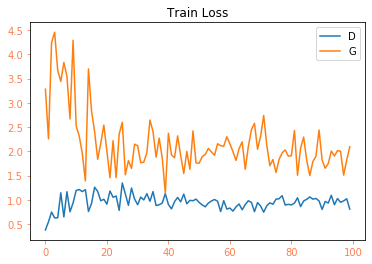

In [29]:
fig, ax = plt.subplots()
losses = np.array(losses)
ax.plot(losses.T[0], label='D')
ax.plot(losses.T[1], label='G')
plt.title('Train Loss')
plt.legend()

### Convert it to images

In [22]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        
    return fig, axes

In [23]:
with open('training_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

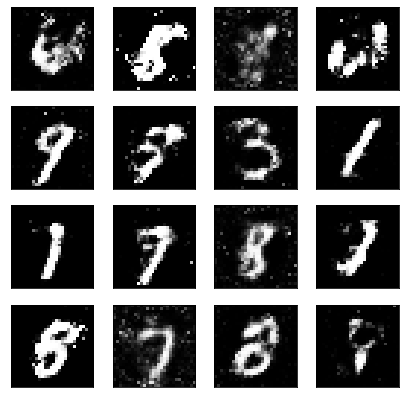

In [24]:
_ = view_samples(-1, samples)

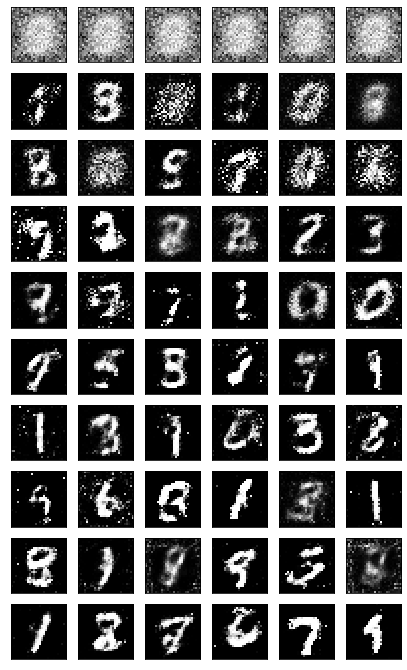

In [25]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7, 12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        

### Generate new images from checkpoint file (new image generation)

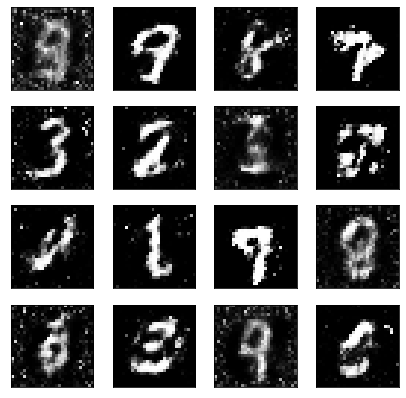

In [30]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                           feed_dict={input_z: sample_z})

_ = view_samples(0, [gen_samples])    
    

### Try the program written above

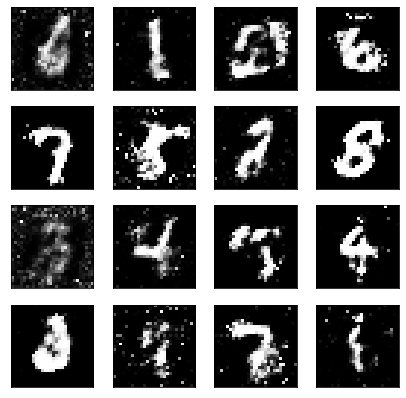

In [34]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                           feed_dict={input_z: sample_z})

_ = view_samples(0, [gen_samples])    
    